# B. State purification with qubit-mediated measurement

In [11]:
# ruff: noqa
import os
os.sys.path.append("..")
from feedback_grape.fgrape_parameterized import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

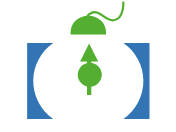

In [12]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [13]:
from feedback_grape.utils.operators import cosm, sinm

In [21]:
from feedback_grape.utils.operators import create, destroy
import jax

# TODO: try to do it as a matrix exponentiation (cos of operator)
# try to see if off diagonal is not 0
def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )


In [22]:
povm_measure_operator(1, 0.1, 0.5)

Array([[ 9.46538687e-01+0.j, -5.59640191e-02+0.j, -5.82155064e-02+0.j,
        -6.02009371e-02+0.j, -6.19076192e-02+0.j, -6.33254498e-02+0.j,
        -6.44468740e-02+0.j, -6.52669966e-02+0.j, -6.57838359e-02+0.j,
        -6.59980029e-02+0.j, -6.59132302e-02+0.j, -6.55358285e-02+0.j,
        -6.48750514e-02+0.j, -6.39429241e-02+0.j, -6.27542138e-02+0.j,
        -6.13260940e-02+0.j, -5.96783236e-02+0.j, -5.78330159e-02+0.j,
        -5.58143705e-02+0.j, -5.36484793e-02+0.j, -5.13633490e-02+0.j,
        -4.89883870e-02+0.j, -4.65542786e-02+0.j, -4.40927744e-02+0.j,
        -4.16363776e-02+0.j, -3.92180271e-02+0.j, -3.68708596e-02+0.j,
        -3.46279144e-02+0.j, -3.25218029e-02+0.j, -3.05845663e-02+0.j],
       [-5.59640005e-02+0.j,  9.36660409e-01+0.j, -6.04670085e-02+0.j,
        -6.23193868e-02+0.j, -6.38888031e-02+0.j, -6.51658475e-02+0.j,
        -6.61434233e-02+0.j, -6.68174848e-02+0.j, -6.71866313e-02+0.j,
        -6.72522485e-02+0.j, -6.70186579e-02+0.j, -6.64929673e-02+0.j,
     

In [ ]:
# TODO: Have a default NN and then give user the ability to supply a model or a function
result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    parameterized_gates=[],
    povm_measure_operator=povm_measure_operator,
    initial_params=jnp.array([[20.0, -10.0]]).reshape((2,1)),
    num_time_steps=5,
    mode="nn",
    goal="purity",
    optimizer="l-bfgs",
    max_iter=1000,
    convergence_threshold=1e-6,
    learning_rate=0.01,
    type="density",
)

2025-05-14 14:28:33.178203: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_while] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-14 14:30:51.213912: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 4m18.041503s

********************************
[Compiling module jit_while] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
from feedback_grape.fgrape_parameterized import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = {"gamma": 20.0, "delta": -10.0}
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.6841599337235187
0.31580850062542604


In [ ]:
from feedback_grape.fgrape_parameterized import purity

print("initial purity:", purity(rho=rho_cav, type="density"))
print("Final purity:", purity(rho=result.final_state, type="density"))
result

initial purity: 0.20000208604889932
Final purity: 0.37455063422848417


fg_result_purity(optimized_parameters={'Dense_0': {'bias': Array([0.0707699 , 0.07454094], dtype=float32), 'kernel': Array([[-0.27570233,  0.05961549],
       [-0.30658668,  0.16525345],
       [-0.06816138,  0.21371022],
       [-0.17981277,  0.00479875],
       [ 0.27939916, -0.26105958],
       [-0.27742997, -0.37939534],
       [-0.16576745, -0.08576322],
       [-0.11846557,  0.46149278],
       [ 0.06058393, -0.2802991 ],
       [-0.13877629, -0.3820929 ],
       [ 0.05969706, -0.31432027],
       [-0.02158997,  0.07098489],
       [ 0.17514542, -0.18846723],
       [ 0.05479385, -0.06710061],
       [ 0.07118447, -0.18750264],
       [ 0.04406795, -0.23496343],
       [-0.13869406,  0.06199734],
       [-0.1567979 ,  0.1739171 ],
       [ 0.03360733, -0.24495234],
       [ 0.26159373,  0.2680625 ],
       [-0.33666435,  0.42962974],
       [-0.24914144,  0.10020949],
       [ 0.15755278,  0.14926212],
       [ 0.1523138 ,  0.29601455],
       [-0.03134889,  0.0857022 ],
       [

In [ ]:
result.arr_of_povm_params

Array([[-0.52350526,  0.53223168],
       [ 1.01374128, -0.56723843],
       [ 0.07235917,  0.2898952 ],
       [ 0.97607009, -0.63034502],
       [ 0.9399878 , -0.96022107]], dtype=float64)

In [ ]:
# Extract POVM parameters from the result
povm_params = result.arr_of_povm_params

# Initialize the state
current_state = rho_cav

# Apply POVM operators for 5 time steps
for t in range(0):
    gamma, delta = povm_params[t]
    variables = {"gamma": gamma, "delta": delta}
    povm_operator = povm_measure_operator(-1, **variables)  # Example with measurement outcome -1
    current_state = povm_operator @ current_state @ povm_operator.T
    current_state /= jnp.trace(current_state)  # Normalize the state

# Calculate the resulting purity
final_purity = purity(rho=current_state, type="density")
print("Resulting purity after 5 time steps:", final_purity)

Resulting purity after 5 time steps: 0.20000208604889932


### Check stash for replacement of dict implementation